# Imports

In [1]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from xgboostlss.model import *
from xgboostlss.distributions.Gaussian import Gaussian
from xgboostlss.datasets.data_loader import load_simulated_data

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Distribution and Quantile Selection

In [ ]:
distribution = Gaussian                   # Estimates both location and scale parameters of the Gaussian simultaneously.
distribution.stabilize = "None"           # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2"
quant_sel = [0.05, 0.95]

# Hyper-Parameter Optimization

In [4]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
params = {"eta": [1e-5, 1],                   
          "max_depth": [1, 10],
          "gamma": [1e-8, 40],
          "subsample": [0.2, 1.0],
          "colsample_bytree": [0.2, 1.0],
          "min_child_weight": [0, 500]
         }

opt_params = xgboostlss.hyper_opt(params,
                                  dtrain=dtrain,
                                  dist=distribution,
                                  num_boost_round=500,       # Number of boosting iterations.
                                  max_minutes=120,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                                  n_trials=500,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                  silence=True)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\xgboostlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/500 [00:00<?, ?it/s]

Hyper-Parameter Optimization successfully finished.
Number of finished trials:  36
Best trial:
  Value: 1460.8463915999998
  Params: 
    eta: 0.024084354161479648
    max_depth: 4
    gamma: 9.595836338769152e-08
    subsample: 0.4982474284249854
    colsample_bytree: 0.970460815026903
    min_child_weight: 66
    opt_rounds: 331


# Model Training

In [ ]:
np.random.seed(123)
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
xgboostlss_model = xgboostlss.train(opt_params,
                                    dtrain,
                                    dist=distribution,
                                    num_boost_round=n_rounds)

# Prediction

In [18]:
# Number of samples to draw from predicted distribution
n_samples=10000

# Using predicted distributional parameters, sample from distribution
pred_y = xgboostlss.predict(xgboostlss_model, 
                            dtest, 
                            dist=distribution,
                            pred_type="response",
                            n_samples=n_samples, 
                            seed=123)

# Using predicted distributional parameters, calculate quantiles
pred_quantiles = xgboostlss.predict(xgboostlss_model, 
                                    dtest, 
                                    dist=distribution,
                                    pred_type="quantiles", 
                                    quantiles=quant_sel, 
                                    seed=123)


# Returns predicted distributional parameters
pred_params = xgboostlss.predict(xgboostlss_model, 
                                 dtest, 
                                 dist=distribution,
                                 pred_type="parameters")

In [19]:
pred_y.head()

,y_pred_sample_0,y_pred_sample_1,y_pred_sample_2,y_pred_sample_3,y_pred_sample_4,y_pred_sample_5,y_pred_sample_6,y_pred_sample_7,y_pred_sample_8,y_pred_sample_9,...,y_pred_sample_9990,y_pred_sample_9991,y_pred_sample_9992,y_pred_sample_9993,y_pred_sample_9994,y_pred_sample_9995,y_pred_sample_9996,y_pred_sample_9997,y_pred_sample_9998,y_pred_sample_9999
0,6.655985,12.901662,10.759676,5.394650,8.176285,14.862914,2.634933,8.625114,13.707015,7.312314,...,6.730620,6.057952,13.123275,15.640997,11.857683,8.118363,5.719570,8.495120,11.656167,12.821506
1,6.923986,12.707270,10.723864,5.756032,8.331732,14.523322,3.200628,8.747332,13.452999,7.531724,...,6.993095,6.370228,12.912476,15.243801,11.740581,8.278098,6.056897,8.626962,11.553984,12.633048
2,8.875194,11.278842,10.454499,8.389769,9.460281,12.033630,7.327693,9.633013,11.588782,9.127782,...,8.903917,8.645041,11.364130,12.333075,10.877067,9.437990,8.514815,9.582985,10.799514,11.247994
3,4.872461,14.456608,11.169677,2.936909,7.205398,17.466199,-1.297946,7.894138,15.692443,5.879614,...,4.986988,3.954764,14.796679,18.660188,12.854597,7.116516,3.435507,7.694660,12.545365,14.333607
4,6.240905,13.317172,10.890331,4.811828,7.963383,15.539244,1.685107,8.471901,14.229626,6.984516,...,6.325464,5.563341,13.568256,16.420802,12.134358,7.897759,5.179958,8.324620,11.906043,13.226356


In [20]:
pred_quantiles.head()

,y_quant_0.05,y_quant_0.95
0,4.979189,14.843175
1,5.371330,14.505045
2,8.229879,12.026033
3,2.299375,17.435910
4,4.341117,15.516881


In [21]:
pred_params.head()

,location,scale
0,9.911182,2.998439
1,9.938188,2.776452
2,10.127956,1.153949
3,9.867642,4.601180
4,9.928999,3.397191


# SHAP Interpretability

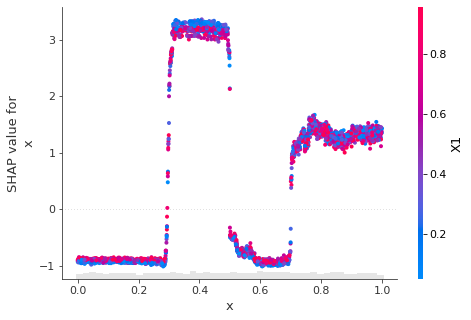

In [22]:
# Partial Dependence Plot of how x acts on variance 
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale",
                feature="x", 
                plot_type="Partial_Dependence")

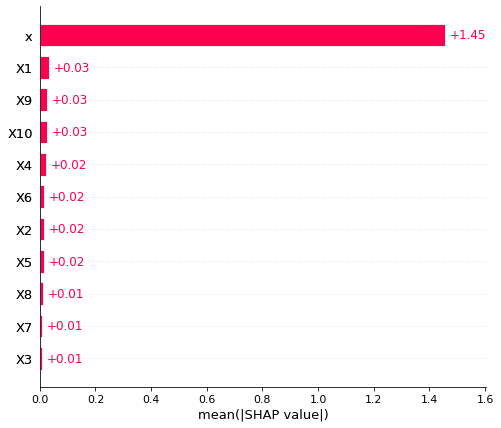

In [23]:
# Feature Importance of features on scale parameter
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale", 
                plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

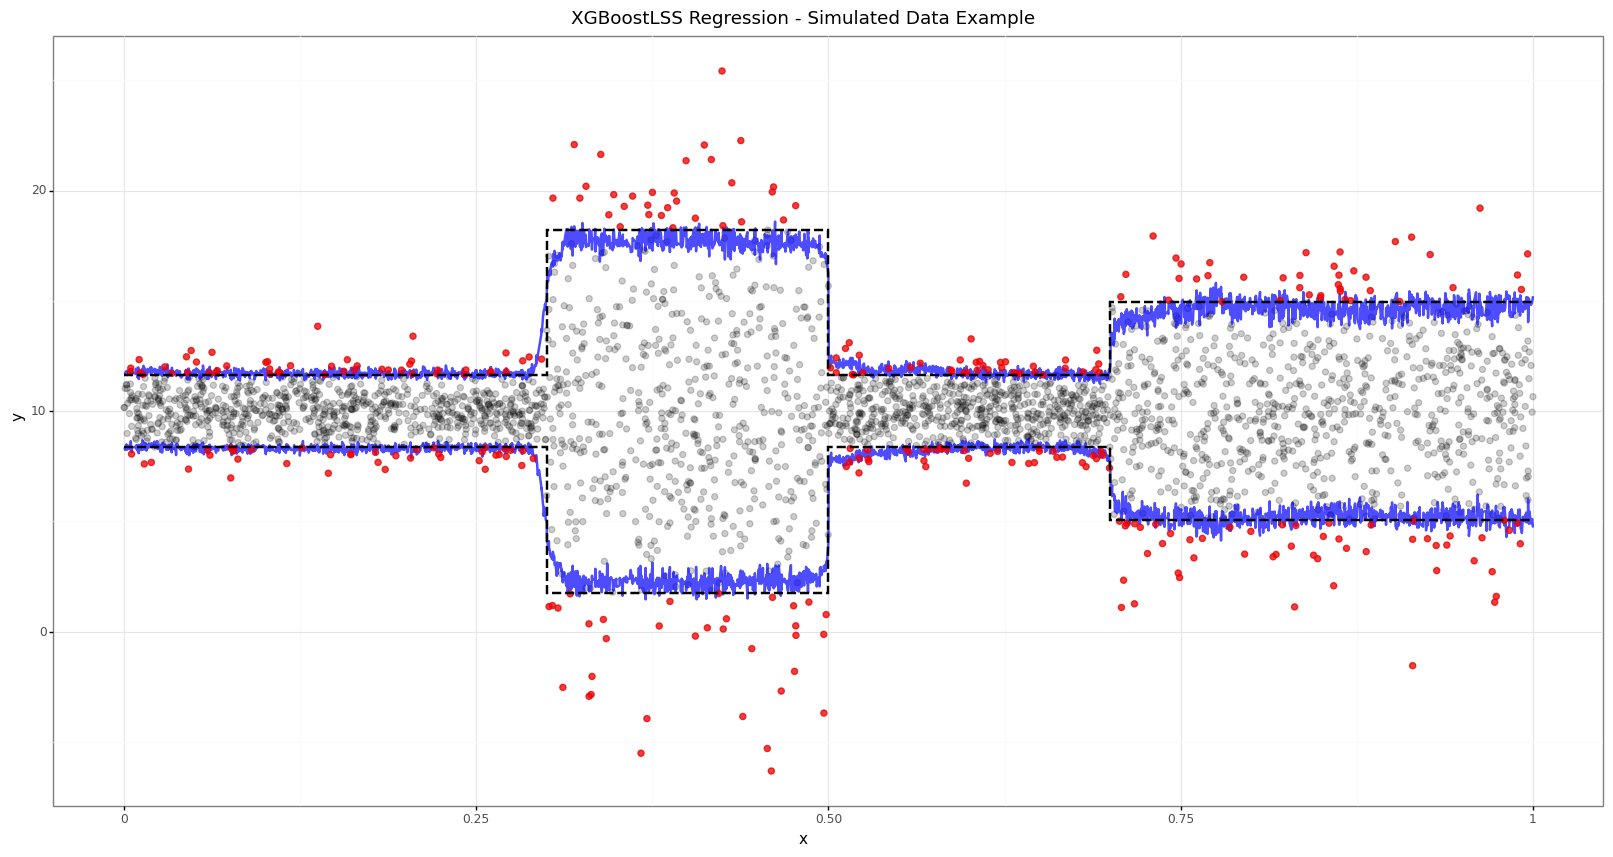

<ggplot: (125404256488)>

In [24]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)